In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error

In [2]:
def create_submission_df(pred):
    new_df = by_month.loc[:,('shop_id','item_id')]
    new_df['target'] = pred
    new_df = sales_test.merge(new_df, on = ['shop_id', 'item_id'], how = 'left')
    new_df['target'].fillna(0,inplace=True)
    return(new_df)

In [3]:
def error(pred, tr_index):
    return(np.sqrt(mean_squared_error(pred, create_y(tr_index))))

In [4]:
def create_submission_file(pred, name):
    new_df = create_submission_df(pred)
    new_df = new_df.loc[:,('ID', 'target')]
    new_df.columns = ['ID', 'item_cnt_month']
    new_df.loc[:,('ID','item_cnt_month')].to_csv('submissions_time_series/'+name+'.csv',index = False)

In [5]:
def expanding_mean_encode(x_tr_index, tr_index, var, times = 5):
    encoded_feature = [0]*by_month.shape[0]
    for i in range(times):
        rows = np.arange(0,by_month.shape[0])
        #np.random.shuffle(rows)
        x_tr = by_month.loc[rows, x_tr_index]
        cum_sum = by_month.groupby(var)[tr_index].cumsum()
        cum_count = by_month.groupby(var).cumcount() + 1
        x_tr[str(var)+'_enc'] = cum_sum/cum_count
        x_tr[str(var)+'_enc'].fillna(by_month[tr_index].mean(), inplace = True)
        encoded_feature += x_tr[str(var)+'_enc']
    x_tr[str(var)+'_enc'] = encoded_feature/times
    return(x_tr)

In [6]:
def max_sum_average(tr_index_init = 0, tr_index = 33, max_num = 1, sum_num = 12, ave_num = 1, expand = True):
    months = np.arange(0,34)
    x_tr_index = ['item_id', 'shop_id', 'item_category_id']
    x_tr_pred_index = x_tr_index.copy()
    x_tr_index.extend(np.arange(tr_index_init,tr_index).tolist())
    x_tr_pred_index.extend(np.arange(tr_index_init+1,tr_index+1).tolist())
    #print(x_tr_index)
    if max_num>0:
        by_month_shopid_max = by_month.groupby('shop_id').max().loc[:,months]
        ##print(by_month_shopid_max)
        #print(by_month_shopid_max.loc[:,(tr_index-max_num):(tr_index-1)])
        x_tr_max = by_month[x_tr_index].join(by_month_shopid_max.loc[:,(tr_index-max_num):(tr_index-1)], 
                                         on = 'shop_id', rsuffix = '_max')
        #print(by_month_shopid_max.columns)
        #print(by_month[x_tr_index].columns)
        #print(x_tr_max.columns)
        x_tr_pred_max = by_month[x_tr_pred_index].join(by_month_shopid_max.loc[:,(tr_index-max_num+1):(tr_index)], 
                                                       on = 'shop_id', rsuffix = '_max')
    else:
        x_tr_max = by_month.loc[:,x_tr_index]
        x_tr_pred_max = by_month.loc[:,x_tr_pred_index]

    #print(x_tr_max.columns)
    if sum_num>0:
        by_month_shopid_sum = by_month.groupby('shop_id').sum(axis = 0).loc[:,months]
        by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,(tr_index-sum_num):(tr_index-1)]
        by_month_cols_sum = by_month_cols_sum.reset_index().drop('shop_id', axis = 1).add_suffix('_sum')
        x_tr_max_sum = x_tr_max.join(by_month_cols_sum)
        
        by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,:].loc[:,(tr_index-sum_num+1):(tr_index)]
        by_month_cols_sum = by_month_cols_sum.reset_index().drop('shop_id', axis = 1).add_suffix('_sum')
        x_tr_pred_max_sum = x_tr_pred_max.join(by_month_cols_sum)
        
    else:
        x_tr_max_sum = x_tr_max
        x_tr_pred_max_sum = x_tr_pred_max
     
    #print(x_tr_max_sum.columns)
    if ave_num>0:
        by_month_shopid_item_count = by_month.groupby('shop_id')['item_id'].count()
        by_month_shopid_average = by_month.groupby('shop_id').sum(axis = 0).divide(by_month_shopid_item_count, axis = 0).loc[:,months]
        by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,(tr_index-ave_num):(tr_index-1)].reset_index().drop('shop_id', axis = 1).add_suffix('_ave')
        x_tr_max_sum_average = x_tr_max_sum.join(by_month_cols_average)
        
        by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,(tr_index-ave_num+1):(tr_index)].reset_index().drop('shop_id', axis = 1).add_suffix('_ave')
        x_tr_pred_max_sum_average = x_tr_pred_max_sum.join(by_month_cols_average)
    else:
        x_tr_max_sum_average = x_tr_max_sum
        x_tr_pred_max_sum_average = x_tr_pred_max_sum
    
    #print(x_tr_max_sum_average.columns)
    if expand:
        x_tr_max_sum_average['item_id_enc'] = expanding_mean_encode(x_tr_index, tr_index, 'item_id',times = 1)['item_id_enc']
        x_tr_max_sum_average['shop_id_enc'] = expanding_mean_encode(x_tr_index, tr_index, 'shop_id',times = 1)['shop_id_enc']
        
        x_tr_pred_max_sum_average['item_id_enc'] = x_tr_max_sum_average['item_id_enc']
        x_tr_pred_max_sum_average['shop_id_enc'] = x_tr_max_sum_average['shop_id_enc']
        
        x_tr_max_sum_average = x_tr_max_sum_average.drop(['shop_id', 'item_id'], axis = 1)
    
    
    x_tr = x_tr_max_sum_average.values
    x_tr_pred_max_sum_average = sales_test.merge(x_tr_pred_max_sum_average, on = ['shop_id', 'item_id']).drop(['ID'], axis = 1)
    if expand: 
        x_tr_pred_max_sum_average=x_tr_pred_max_sum_average.drop(['shop_id', 'item_id'], axis = 1)
    x_tr_pred = x_tr_pred_max_sum_average.values
    
    return(x_tr_max_sum_average, x_tr, x_tr_pred_max_sum_average, x_tr_pred)

In [7]:
def create_y(tr_index):
    val = sales_test.merge(by_month.loc[:,['item_id','shop_id',tr_index+1]], 
                           on = ['shop_id', 'item_id']).drop(['ID','shop_id', 'item_id'], axis = 1)
    return(val)

In [8]:
sales_train = pd.read_csv(r'F:\Old_Desktop\Machine Learning Projects\Time Series\sales_train_v2.csv')
items = pd.read_csv(r'F:\Old_Desktop\Machine Learning Projects\Time Series\items.csv')
item_categories = pd.read_csv(r'F:\Old_Desktop\Machine Learning Projects\Time Series\item_categories.csv')
shops = pd.read_csv(r'F:\Old_Desktop\Machine Learning Projects\Time Series\shops.csv')
sales_test = pd.read_csv(r'F:\Old_Desktop\Machine Learning Projects\Time Series\test.csv')

In [4]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales_train.shape

(2935849, 6)

In [7]:
sales_train.nunique(axis = 0)

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [59]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
sales_test.shape

(214200, 3)

In [9]:
sales_test.nunique(dropna = False)

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [9]:
by_month = pd.pivot_table(sales_train, index= ('item_id','shop_id'), values='item_cnt_day', columns='date_block_num',aggfunc = sum)

In [10]:
by_month[by_month.isnull()] = 0
by_month = by_month.reset_index()

In [11]:
by_month = by_month.join(items.loc[:,('item_id','item_category_id')].set_index('item_id'), on='item_id')

In [6]:
by_month

,item_id,shop_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_id
0,0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,1,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76
2,2,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,3,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,4,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
5,5,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
6,6,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
7,7,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
8,8,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
9,9,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


Applying Random Forest to the above data to understand the base score

In [18]:
by_month.columns

Index([         'item_id',          'shop_id',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10,                 11,                 12,
                       13,                 14,                 15,
                       16,                 17,                 18,
                       19,                 20,                 21,
                       22,                 23,                 24,
                       25,                 26,                 27,
                       28,                 29,                 30,
                       31,                 32,                 33,
       'item_category_id'],
      dtype='object')

In [53]:
x_tr_index = ['item_id', 'shop_id', 'item_category_id']
tr_index = 21 # y for training
x_tr_index.extend(np.arange(0,tr_index).tolist())
x_tr = by_month[x_tr_index].values
x_te = by_month[tr_index].values

In [54]:
x_tr.shape

(424124, 24)

In [55]:
x_tr_pred_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_pred_index.extend(np.arange(1,tr_index+1).tolist())
x_tr_pred = by_month[x_tr_pred_index].values
x_te_pred = by_month[tr_index+1].values

In [285]:
x_tr_pred.shape

(424124, 24)

In [287]:
rf = RandomForestRegressor(max_features='sqrt', max_depth=10, n_estimators=100, random_state = 24)

In [288]:
rf.fit(x_tr, x_te)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=24, verbose=0, warm_start=False)

In [289]:
error(rf.predict(x_tr), x_te)

1.1738566628711373

In [290]:
error(rf.predict(x_tr_pred), x_te_pred)

2.744856409359998

Trying feature encoding of shop ids and item ids

In [59]:
x_tr = expanding_mean_encode(x_tr_index, tr_index, 'item_id',times = 1)

In [52]:
x_tr

array([[ 0., 54., 40., ...,  0.,  0.,  1.],
       [ 1., 55., 76., ...,  1.,  1.,  1.],
       [ 0., 54., 40., ...,  0.,  1.,  0.],
       ...,
       [ 0., 42., 62., ...,  0.,  0.,  0.],
       [ 0., 43., 62., ...,  0.,  0.,  0.],
       [ 0., 25., 69., ...,  0.,  0.,  0.]])

In [53]:
rf.fit(x_tr,x_te)
print(error(rf.predict(x_tr),x_te))

1.0194687708265937

In [57]:
x_tr_pred[:,0] = x_tr[:,0]
print(error(rf.predict(x_tr_pred), x_te_pred))

2.7378107837478933


In [58]:
x_tr[:,1] = expanding_mean_encode(x_tr_index, tr_index,'shop_id', times=1)[:,1]

In [59]:
rf.fit(x_tr,x_te)
error(rf.predict(x_tr),x_te)

0.9776210024659762

In [60]:
x_tr_pred[:,1] = x_tr[:,1]

In [61]:
error(rf.predict(x_tr_pred),x_te_pred)

2.7146221457353357

In [62]:
x_tr[:,2] = expanding_mean_encode(x_tr_index, tr_index,'item_category_id', times=1)[:,2]

In [63]:
rf.fit(x_tr,x_te)
error(rf.predict(x_tr),x_te)

0.9757683207617935

In [64]:
x_tr_pred[:,2] = x_tr[:,2]

In [65]:
error(rf.predict(x_tr_pred),x_te_pred)

2.721588920604293

In [66]:
x_tr[:,2] = by_month['item_category_id']

In [67]:
x_tr_pred[:,2] = by_month['item_category_id']

Adding previous months max shop wise

In [47]:
months = np.arange(0,34)

In [70]:
by_month_shopid_max = by_month.groupby('shop_id').max().loc[:,months]

In [135]:
x_tr_max = by_month[x_tr_index].join(by_month_shopid_max[tr_index-1], on = 'shop_id', rsuffix = '_max')
x_tr_max['item_id'] = expanding_mean_encode(x_tr_index, tr_index, 'item_id',times = 1)[:,0]
x_tr_max['shop_id'] = expanding_mean_encode(x_tr_index, tr_index, 'shop_id',times = 1)[:,1]
x_tr = x_tr_max.values

In [137]:
x_tr_pred_max = pd.DataFrame(by_month[x_tr_pred_index]).join(by_month_shopid_max[tr_index], on = 'shop_id', rsuffix = '_max')
x_tr_pred_max['item_id'] = x_tr[:,0]
x_tr_pred_max['shop_id'] = x_tr[:,1]
x_tr_pred = x_tr_pred_max.values

In [138]:
rf.fit(x_tr, x_te)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=24, verbose=0, warm_start=False)

In [139]:
print(error(rf.predict(x_tr),x_te))
print(error(rf.predict(x_tr_pred),x_te_pred))

0.9098724462358695
2.7040353001506015


In [140]:
by_month_shopid_sum = by_month.groupby('shop_id').sum(axis = 0).loc[:,months]

In [203]:
by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,:].loc[:,(tr_index-6):(tr_index-1)]
by_month_cols_sum = by_month_cols_sum.add_suffix('_sum').reset_index().drop('shop_id', axis = 1)

In [207]:
x_tr_max_sum = x_tr_max.join(by_month_cols_sum)
x_tr = x_tr_max_sum.values

In [208]:
by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,:].loc[:,(tr_index-5):(tr_index)]
by_month_cols_sum = by_month_cols_sum.add_suffix('_sum').reset_index().drop('shop_id', axis = 1)

In [211]:
x_tr_pred_max_sum = x_tr_pred_max.join(by_month_cols_sum)
x_tr_pred = x_tr_pred_max_sum.values

In [212]:
rf.fit(x_tr, x_te)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=24, verbose=0, warm_start=False)

In [213]:
print(error(rf.predict(x_tr),x_te))
print(error(rf.predict(x_tr_pred),x_te_pred))

0.9235328776463213
2.7163689002765268


In [237]:
by_month_shopid_item_count = by_month.groupby('shop_id')['item_id'].count()
by_month_shopid_average = by_month.groupby('shop_id').sum(axis = 0).divide(by_month_shopid_item_count, axis = 0).loc[:,months] 

In [243]:
by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,(tr_index-12):(tr_index-1)].reset_index().drop('shop_id', axis = 1).add_suffix('_ave')
x_tr_max_sum_average = x_tr_max_sum.join(by_month_cols_average)

In [419]:
by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,(tr_index-11):(tr_index)].reset_index().drop('shop_id', axis = 1).add_suffix('_ave')
x_tr_pred_max_sum_average = x_tr_pred_max_sum.join(by_month_cols_average)

In [248]:
x_tr_max_sum_average.shape

(424124, 43)

In [249]:
x_tr_pred_max_sum_average.shape

(424124, 43)

In [250]:
rf.fit(x_tr_max_sum_average.values, x_te)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=24, verbose=0, warm_start=False)

In [251]:
print(error(rf.predict(x_tr_max_sum_average.values),x_te))
print(error(rf.predict(x_tr_pred_max_sum_average.values),x_te_pred))

0.9500088366600667
2.7311910270930055


Just adding 12th month previous average and 12 month sum 

In [291]:
by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,:].loc[:,(tr_index-12):(tr_index-1)]
by_month_cols_sum = by_month_cols_sum.add_suffix('_sum').reset_index().drop('shop_id', axis = 1)

In [292]:
x_tr_max_sum_12 = x_tr_max.join(by_month_cols_sum)
x_tr = x_tr_max_sum_12.values

In [293]:
by_month_cols_sum = by_month_shopid_sum.loc[by_month['shop_id'].values,:].loc[:,(tr_index-11):(tr_index)]
by_month_cols_sum = by_month_cols_sum.add_suffix('_sum').reset_index().drop('shop_id', axis = 1)

In [294]:
x_tr_pred_max_sum_12 = x_tr_pred_max.join(by_month_cols_sum)
x_tr_pred = x_tr_pred_max_sum_12.values

In [299]:
rf.fit(x_tr_max_sum_12.values, x_te)
print(error(rf.predict(x_tr_max_sum_12.values),x_te))
print(error(rf.predict(x_tr_pred_max_sum_12.values),x_te_pred))

0.9187052651480402
2.7054658084055205


In [304]:
by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,tr_index-12].reset_index().drop('shop_id', axis = 1).add_suffix('_ave')
x_tr_max_sum_12_average_1 = x_tr_max_sum_12.join(by_month_cols_average, rsuffix = '_ave')
by_month_cols_average = by_month_shopid_average.loc[by_month['shop_id'].values,tr_index-11].reset_index().drop('shop_id', axis = 1)..add_suffix('_ave')
x_tr_pred_max_sum_12_average_1 = x_tr_pred_max_sum_12.join(by_month_cols_average, rsuffix = '_ave')

In [308]:
rf.fit(x_tr_max_sum_12_average_1.values, x_te)
print(error(rf.predict(x_tr_max_sum_12_average_1.values),x_te))
print(error(rf.predict(x_tr_pred_max_sum_12_average_1.values),x_te_pred))

0.9314531509320796
2.7076184460374715


***Try xgboost on this dataset***

In [226]:
xgbalg = XGBRegressor(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 15, gamma = 0,
                    subsample = 1, colsample_bytree=0.8, seed = 21, silent = True)

In [233]:
xgtrain = xgb.DMatrix(x_tr_max_sum.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max_sum.values, x_te_pred)

In [234]:
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=5000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.53497
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.92963
[20]	test-rmse-rmse:2.91764
[30]	test-rmse-rmse:2.93362
[40]	test-rmse-rmse:2.96821
[50]	test-rmse-rmse:2.98603
[60]	test-rmse-rmse:2.99905
Stopping. Best iteration:
[15]	test-rmse-rmse:2.90627



In [236]:
x_tr_max_sum.values.shape

(424124, 31)

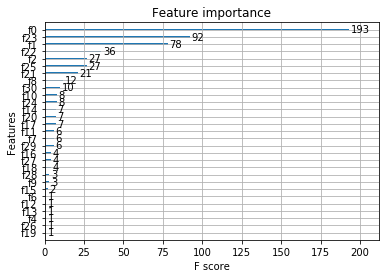

In [235]:
xgb.plot_importance(xgbresults)

In [229]:
xgtrain = xgb.DMatrix(x_tr_max.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max.values, x_te_pred)

In [230]:
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=5000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.5332
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.93124
[20]	test-rmse-rmse:2.92817
[30]	test-rmse-rmse:2.9674
[40]	test-rmse-rmse:2.98528
[50]	test-rmse-rmse:3.00553
[60]	test-rmse-rmse:3.01345
Stopping. Best iteration:
[15]	test-rmse-rmse:2.91011



In [232]:
x_tr_max.values.shape

(424124, 25)

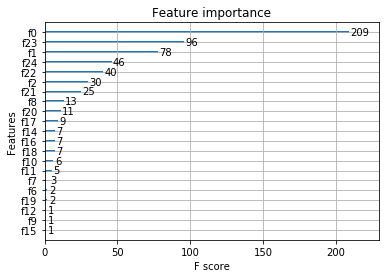

In [231]:
xgb.plot_importance(xgbresults)

In [252]:
xgtrain = xgb.DMatrix(x_tr_max_sum_average.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max_sum_average.values, x_te_pred)

In [253]:
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=5000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.5735
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.97095
[20]	test-rmse-rmse:2.92633
[30]	test-rmse-rmse:2.94672
[40]	test-rmse-rmse:2.9733
[50]	test-rmse-rmse:3.01219
[60]	test-rmse-rmse:3.05738
Stopping. Best iteration:
[17]	test-rmse-rmse:2.92159



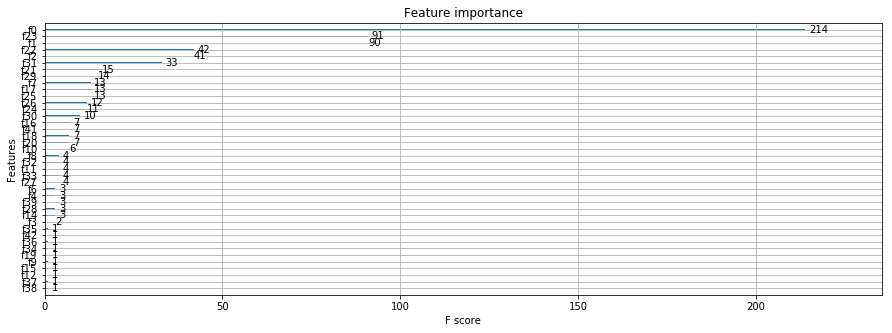

In [268]:
xgb.plot_importance(xgbresults, height = 0.1)

**Using last 12 months average does not work really well!**

In [309]:
xgtrain = xgb.DMatrix(x_tr_max_sum_12.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max_sum_12.values, x_te_pred)
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=5000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.53394
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.94116
[20]	test-rmse-rmse:2.91763
[30]	test-rmse-rmse:2.94044
[40]	test-rmse-rmse:2.9622
[50]	test-rmse-rmse:2.99376
[60]	test-rmse-rmse:3.01053
Stopping. Best iteration:
[17]	test-rmse-rmse:2.91026



In [310]:
xgtrain = xgb.DMatrix(x_tr_max_sum_12_average_1.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max_sum_12_average_1.values, x_te_pred)
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=5000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.53279
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.92482
[20]	test-rmse-rmse:2.91025
[30]	test-rmse-rmse:2.93966
[40]	test-rmse-rmse:2.96597
[50]	test-rmse-rmse:3.00811
[60]	test-rmse-rmse:3.03413
Stopping. Best iteration:
[17]	test-rmse-rmse:2.90411



In [312]:
x_tr_max_sum_12_average_1.shape

(424124, 38)

In [313]:
x_tr_max_sum_12_average_1.columns

Index([         'item_id',          'shop_id', 'item_category_id',
                        0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                      '9',                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,               '20',
                 '20_max',            '9_sum',           '10_sum',
                 '11_sum',           '12_sum',           '13_sum',
                 '14_sum',           '15_sum',           '16_sum',
                 '17_sum',           '18_sum',           '19_sum',
                 '20_sum',            '9_ave'],
      dtype='object')

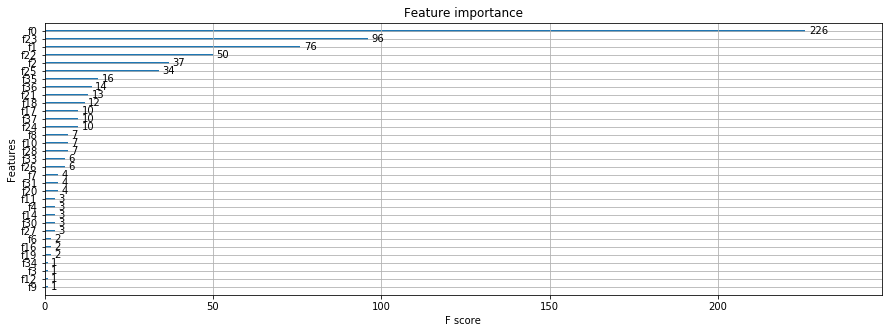

In [311]:
xgb.plot_importance(xgbresults)

**So far: max_num = 1, sum_num = 12, ave_num = 1**

Check results for tr_index = 20

In [16]:
xgbalg = XGBRegressor(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 15, gamma = 0,
                    subsample = 1, colsample_bytree=0.8, seed = 21, silent = True)

In [126]:
tr_index = 20
tr_index_init = 9

In [82]:
[x_tr_max_sum_average, x_tr, x_tr_pred_max_sum_average, x_tr_pred] = max_sum_average(tr_index_init=tr_index_init, 
                                                                                     tr_index=tr_index, max_num=1, sum_num=12, 
                                                                                     ave_num=1, expand=True)

In [83]:
x_tr_max_sum_average.columns

Index(['item_category_id',                  9,                 10,
                       11,                 12,                 13,
                       14,                 15,                 16,
                       17,                 18,               '19',
                 '19_max',            '8_sum',            '9_sum',
                 '10_sum',           '11_sum',           '12_sum',
                 '13_sum',           '14_sum',           '15_sum',
                 '16_sum',           '17_sum',           '18_sum',
                 '19_sum',           '19_ave',      'item_id_enc',
            'shop_id_enc'],
      dtype='object')

In [84]:
x_tr_max_sum_average.shape

(424124, 28)

In [85]:
x_tr_pred_max_sum_average.shape

(111404, 28)

In [127]:
x_te = by_month[tr_index]
x_te_pred = create_y(tr_index)
#sales_test.merge(by_month.loc[:,['item_id','shop_id',tr_index+1]], on = ['shop_id', 'item_id']).drop(['ID','shop_id', 'item_id'], axis = 1)

In [103]:
x_tr_pred_max_sum_average.columns

Index(['item_category_id',                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,               '20',
                 '20_max',            '9_sum',           '10_sum',
                 '11_sum',           '12_sum',           '13_sum',
                 '14_sum',           '15_sum',           '16_sum',
                 '17_sum',           '18_sum',           '19_sum',
                 '20_sum',           '20_ave',      'item_id_enc',
            'shop_id_enc'],
      dtype='object')

In [104]:
x_tr_max_sum_average.columns

Index(['item_category_id',                  9,                 10,
                       11,                 12,                 13,
                       14,                 15,                 16,
                       17,                 18,               '19',
                 '19_max',            '8_sum',            '9_sum',
                 '10_sum',           '11_sum',           '12_sum',
                 '13_sum',           '14_sum',           '15_sum',
                 '16_sum',           '17_sum',           '18_sum',
                 '19_sum',           '19_ave',      'item_id_enc',
            'shop_id_enc'],
      dtype='object')

In [128]:
xgtrain = xgb.DMatrix(x_tr_max_sum_average.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_max_sum_average.values, x_te_pred)
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds = 50, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:3.96277
Will train until test-rmse-rmse hasn't improved in 50 rounds.
[10]	test-rmse-rmse:2.57509
[20]	test-rmse-rmse:2.34406
[30]	test-rmse-rmse:2.28768
[40]	test-rmse-rmse:2.28155
[50]	test-rmse-rmse:2.27079
[60]	test-rmse-rmse:2.27288
[70]	test-rmse-rmse:2.28465
[80]	test-rmse-rmse:2.29373
[90]	test-rmse-rmse:2.2966
[100]	test-rmse-rmse:2.29956
[110]	test-rmse-rmse:2.31168
Stopping. Best iteration:
[62]	test-rmse-rmse:2.27005



In [138]:
tr_index = 32
tr_init_index = 21
[_,_,x_test_df, x_test] = max_sum_average(tr_index_init=tr_init_index, tr_index=tr_index, max_num=1, sum_num=12, ave_num=1, expand=True)

In [139]:
x_test_1.columns

Index(['item_category_id',                 21,                 22,
                       23,                 24,                 25,
                       26,                 27,                 28,
                       29,                 30,               '31',
                 '31_max',           '20_sum',           '21_sum',
                 '22_sum',           '23_sum',           '24_sum',
                 '25_sum',           '26_sum',           '27_sum',
                 '28_sum',           '29_sum',           '30_sum',
                 '31_sum',           '31_ave',      'item_id_enc',
            'shop_id_enc'],
      dtype='object')

In [140]:
x_test_df.columns

Index(['item_category_id',                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,               '32',
                 '32_max',           '21_sum',           '22_sum',
                 '23_sum',           '24_sum',           '25_sum',
                 '26_sum',           '27_sum',           '28_sum',
                 '29_sum',           '30_sum',           '31_sum',
                 '32_sum',           '32_ave',      'item_id_enc',
            'shop_id_enc'],
      dtype='object')

In [141]:
print(error(xgbresults.predict(xgtrain), x_te))

0.9371722236932865


In [124]:
np.sqrt(mean_squared_error(xgbresults.predict(xgtest), x_te_pred))

2.3095438737635194

In [142]:
y_test = xgbresults.predict(xgb.DMatrix(x_test))

In [150]:
error(y_test, tr_index)

6.751686624925714

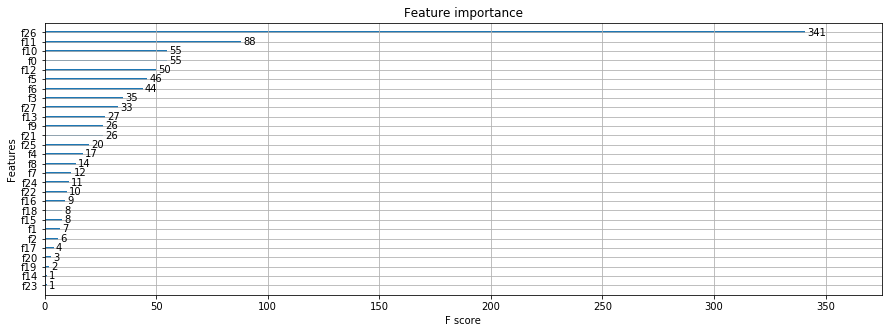

In [147]:
xgb.plot_importance(xgbresults)

Check if performance same with tr_index = 32 

In [13]:
xgbalg = XGBRegressor(learning_rate = 0.2, n_estimators = 1000, max_depth = 10, min_child_weight = 1000, gamma = 0,
                    subsample = 0.5, colsample_bytree=1, seed = 24, silent = True)

In [14]:
tr_index = 32
tr_index_init = 0

In [15]:
[x_tr_max_sum_average, x_tr, x_tr_pred_max_sum_average, x_tr_pred] = max_sum_average(tr_index_init=tr_index_init, 
                                                                                     tr_index=tr_index, max_num=1, 
                                                                                     sum_num=12, ave_num=1)

In [16]:
x_tr_max_sum_average.columns

Index(['item_category_id',                  0,                  1,
                        2,                  3,                  4,
                        5,                  6,                  7,
                        8,                  9,                 10,
                       11,                 12,                 13,
                       14,                 15,                 16,
                       17,                 18,                 19,
                       20,                 21,                 22,
                       23,                 24,                 25,
                       26,                 27,                 28,
                       29,                 30,               '31',
                 '31_max',           '20_sum',           '21_sum',
                 '22_sum',           '23_sum',           '24_sum',
                 '25_sum',           '26_sum',           '27_sum',
                 '28_sum',           '29_sum',           '30_s

In [17]:
x_tr_pred_max_sum_average.columns

Index(['item_category_id',                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,               '32',
                 '32_max',           '21_sum',           '22_sum',
                 '23_sum',           '24_sum',           '25_sum',
                 '26_sum',           '27_sum',           '28_sum',
                 '29_sum',           '30_sum',           '31_s

In [18]:
x_te = by_month[tr_index]
x_te_pred = create_y(tr_index)

In [ ]:
xgtrain = xgb.DMatrix(x_tr, x_te)
xgtest = xgb.DMatrix(x_tr_pred, x_te_pred)
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds = 30, verbose_eval=10,
                      evals = [(xgtest, 'test-rmse')])

[0]	test-rmse-rmse:7.64716
Will train until test-rmse-rmse hasn't improved in 30 rounds.
[10]	test-rmse-rmse:7.60428


In [579]:
error(xgbresults.predict(xgtrain), x_te)

2.2322772413720293

In [580]:
error(xgbresults.predict(xgtest), x_te_pred)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000026F5F164240>>
Traceback (most recent call last):
  File "F:\Python\lib\site-packages\xgboost-0.71-py3.6.egg\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000026F02B69358>>
Traceback (most recent call last):
  File "F:\Python\lib\site-packages\xgboost-0.71-py3.6.egg\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


5.480500397751413

Trying Catboost with categorical features

In [383]:
from catboost import CatBoostRegressor

In [387]:
i = tr_index
x_tr_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_index.extend(np.arange(tr_index-i,tr_index+1).tolist())
x_tr = by_month[x_tr_index].values
te_index = tr_index+1
x_te = by_month[te_index].values

x_tr_pred_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_pred_index.extend(np.arange(tr_index-i+1,tr_index+2).tolist())
x_tr_pred = by_month[x_tr_pred_index].values
x_te_pred = by_month[te_index+1].values

In [385]:
x_tr.shape

(424124, 35)

In [388]:
x_tr_pred.shape

(424124, 35)

In [398]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 300, l2_leaf_reg = 1, depth = 6, one_hot_max_size=2, metric_period=30,
                       rsm = 0.7)
cat.fit(x_tr, x_te, cat_features = cat_features)

0:	learn: 4.8058445	total: 641ms	remaining: 3m 11s
30:	learn: 2.1459048	total: 13.8s	remaining: 2m
60:	learn: 1.3224343	total: 29s	remaining: 1m 53s
90:	learn: 1.0710105	total: 42.9s	remaining: 1m 38s
120:	learn: 0.9478056	total: 57.2s	remaining: 1m 24s
150:	learn: 0.8729653	total: 1m 12s	remaining: 1m 11s
180:	learn: 0.8171830	total: 1m 26s	remaining: 56.9s
210:	learn: 0.7762640	total: 1m 41s	remaining: 42.8s
240:	learn: 0.7520354	total: 1m 57s	remaining: 28.7s
270:	learn: 0.7290384	total: 2m 12s	remaining: 14.2s
299:	learn: 0.7037876	total: 2m 25s	remaining: 0us


In [399]:
cat.score(x_tr, x_te)

1.5808061535877806

In [400]:
cat.score(x_tr_pred, x_te_pred)

4.7159103668225537

<Container object of 35 artists>

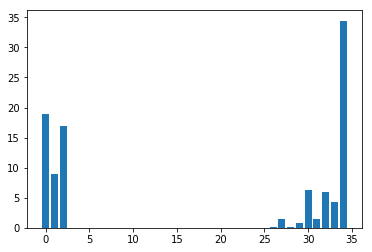

In [419]:
ind = np.arange(len(cat.feature_importances_.tolist()))
plt.bar(ind, cat.feature_importances_.tolist()) 

In [421]:
i = 8
x_tr_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_index.extend(np.arange(tr_index-i,tr_index+1).tolist())
x_tr = by_month[x_tr_index].values
te_index = tr_index+1
x_te = by_month[te_index].values

x_tr_pred_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_pred_index.extend(np.arange(tr_index-i+1,tr_index+2).tolist())
x_tr_pred = by_month[x_tr_pred_index].values
x_te_pred = by_month[te_index+1].values

In [423]:
x_tr.shape

(424124, 12)

In [425]:
x_tr_pred.shape

(424124, 12)

In [426]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 300, l2_leaf_reg = 1, depth = 6, one_hot_max_size=2, metric_period=30,
                       rsm = 0.7)
cat.fit(x_tr, x_te, cat_features = cat_features)

0:	learn: 4.8191510	total: 598ms	remaining: 2m 58s
30:	learn: 1.8526607	total: 13s	remaining: 1m 52s
60:	learn: 1.2516952	total: 25.4s	remaining: 1m 39s
90:	learn: 1.0139677	total: 38s	remaining: 1m 27s
120:	learn: 0.9158535	total: 51.6s	remaining: 1m 16s
150:	learn: 0.8441025	total: 1m 3s	remaining: 1m 2s
180:	learn: 0.8065659	total: 1m 14s	remaining: 49.2s
210:	learn: 0.7769005	total: 1m 26s	remaining: 36.7s
240:	learn: 0.7532703	total: 1m 39s	remaining: 24.3s
270:	learn: 0.7307512	total: 1m 51s	remaining: 12s
299:	learn: 0.7104555	total: 2m 2s	remaining: 0us


In [427]:
cat.score(x_tr, x_te)

1.6417495942166527

In [428]:
cat.score(x_tr_pred, x_te_pred)

4.2235296149090393

In [435]:
i = tr_index
x_tr_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_index.extend(np.arange(tr_index-i,tr_index+2).tolist())
x_tr = by_month[x_tr_index].values
te_index = tr_index+2
x_te = by_month[te_index].values

x_tr_pred_index = ['item_id', 'shop_id', 'item_category_id']
x_tr_pred_index.extend(np.arange(tr_index-i+1,tr_index+3).tolist())
x_tr_pred = by_month[x_tr_pred_index].values
#x_te_pred = by_month[te_index+1].values

In [430]:
x_tr.shape

(424124, 36)

In [431]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 300, l2_leaf_reg = 1, depth = 6, one_hot_max_size=2, metric_period=30,
                       rsm = 0.7)
cat.fit(x_tr, x_te, cat_features = cat_features)

0:	learn: 3.8217929	total: 477ms	remaining: 2m 22s
30:	learn: 1.3555334	total: 14.2s	remaining: 2m 3s
60:	learn: 0.9961963	total: 29.5s	remaining: 1m 55s
90:	learn: 0.9315647	total: 43.8s	remaining: 1m 40s
120:	learn: 0.9007517	total: 58.4s	remaining: 1m 26s
150:	learn: 0.8752005	total: 1m 12s	remaining: 1m 11s
180:	learn: 0.8599238	total: 1m 27s	remaining: 57.4s
210:	learn: 0.8396671	total: 1m 41s	remaining: 43s
240:	learn: 0.8242110	total: 1m 57s	remaining: 28.7s
270:	learn: 0.8107804	total: 2m 11s	remaining: 14.1s
299:	learn: 0.7968987	total: 2m 24s	remaining: 0us


In [432]:
cat.score(x_tr, x_te)

0.88594188490406944

In [446]:
pred_tr = np.round(cat.predict(x_tr))

In [445]:
np.round(1.51)

2.0

In [452]:
error(np.clip(pred_tr,0,1e10), x_te)

1.0284764324842532

In [448]:
error(cat.predict(x_tr), x_te)

1.0154866552084254

<Container object of 36 artists>

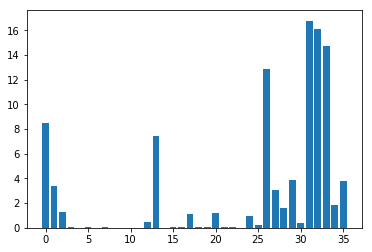

In [433]:
ind = np.arange(len(cat.feature_importances_.tolist()))
plt.bar(ind, cat.feature_importances_.tolist()) 

In [455]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 300, l2_leaf_reg = 1, depth = 6, one_hot_max_size=90, metric_period=30,
                       rsm = 0.7)
cat.fit(x_tr, x_te, cat_features = cat_features)

0:	learn: 3.8213041	total: 303ms	remaining: 1m 30s
30:	learn: 1.3780559	total: 10.5s	remaining: 1m 30s
60:	learn: 1.0357754	total: 20.3s	remaining: 1m 19s
90:	learn: 0.9469658	total: 30.3s	remaining: 1m 9s
120:	learn: 0.8986377	total: 40.3s	remaining: 59.7s
150:	learn: 0.8643237	total: 50.3s	remaining: 49.6s
180:	learn: 0.8336663	total: 1m 1s	remaining: 40.5s
210:	learn: 0.8006472	total: 1m 11s	remaining: 30.3s
240:	learn: 0.7832023	total: 1m 22s	remaining: 20.1s
270:	learn: 0.7679338	total: 1m 32s	remaining: 9.88s
299:	learn: 0.7597068	total: 1m 42s	remaining: 0us


In [459]:
error(cat.predict(x_tr), x_te)

0.88826447989052859

In [458]:
create_submission_file(cat.predict(x_tr_pred), 'cat3')

In [481]:
by_month_corr = by_month.iloc[:,2:36].corr('kendall')

In [482]:
by_month_corr

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.000000,0.342357,0.252005,0.204598,0.186263,0.164640,0.157740,0.145135,0.122797,0.090734,...,-0.035914,-0.036512,-0.039043,-0.037880,-0.045142,-0.048064,-0.050042,-0.058670,-0.055567,-0.063819
1,0.342357,1.000000,0.301607,0.235038,0.213814,0.189294,0.173147,0.165390,0.141652,0.103612,...,-0.029553,-0.026380,-0.030129,-0.030484,-0.037115,-0.041179,-0.044103,-0.051148,-0.048928,-0.056229
2,0.252005,0.301607,1.000000,0.343184,0.297864,0.258443,0.240648,0.222555,0.190375,0.145785,...,-0.013559,-0.009860,-0.013759,-0.018882,-0.027714,-0.030811,-0.033432,-0.040252,-0.041155,-0.048342
3,0.204598,0.235038,0.343184,1.000000,0.337552,0.286831,0.266498,0.242221,0.204464,0.164020,...,-0.002210,-0.000815,-0.004245,-0.006278,-0.016650,-0.021709,-0.023980,-0.031486,-0.032779,-0.038985
4,0.186263,0.213814,0.297864,0.337552,1.000000,0.336818,0.305878,0.277909,0.232109,0.187330,...,0.007509,0.008012,0.005928,0.002037,-0.008166,-0.015913,-0.017672,-0.023320,-0.025349,-0.034138
5,0.164640,0.189294,0.258443,0.286831,0.336818,1.000000,0.355226,0.318359,0.258902,0.204459,...,0.005333,0.007011,0.002439,-0.002264,-0.011993,-0.018144,-0.018855,-0.024485,-0.025482,-0.034057
6,0.157740,0.173147,0.240648,0.266498,0.305878,0.355226,1.000000,0.374318,0.309682,0.244241,...,0.017858,0.019105,0.011928,0.005933,-0.004868,-0.009481,-0.011831,-0.018248,-0.021614,-0.031044
7,0.145135,0.165390,0.222555,0.242221,0.277909,0.318359,0.374318,1.000000,0.374588,0.291841,...,0.030522,0.031540,0.023637,0.017569,0.006094,-0.003105,-0.004926,-0.011786,-0.016920,-0.027810
8,0.122797,0.141652,0.190375,0.204464,0.232109,0.258902,0.309682,0.374588,1.000000,0.345934,...,0.047386,0.044315,0.037251,0.027938,0.018608,0.010473,0.007011,-0.001789,-0.002640,-0.015510
9,0.090734,0.103612,0.145785,0.164020,0.187330,0.204459,0.244241,0.291841,0.345934,1.000000,...,0.061051,0.055797,0.046959,0.036324,0.026287,0.019732,0.012840,0.007404,0.003671,-0.009442


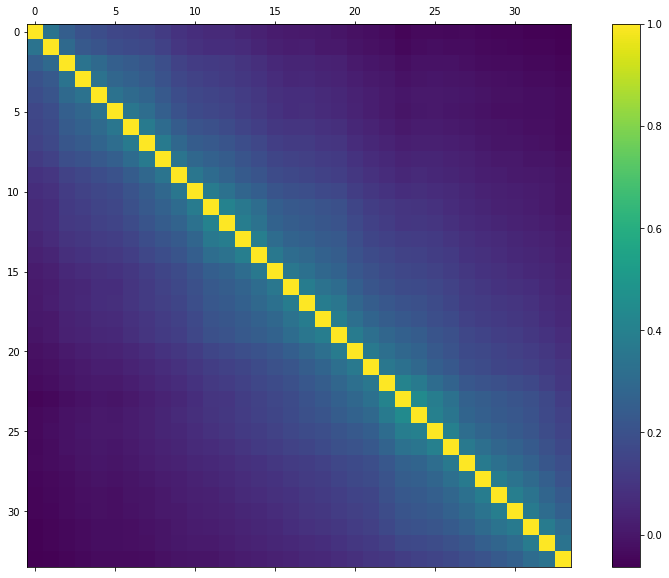

In [483]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(by_month_corr)
fig.colorbar(cax)